# SVM classification for PTM (frontocentral electrodes)

## Yifan Gao 2025-04-09

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from scipy import stats
from scipy.io import loadmat
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.interpolate import interp1d
from scipy.signal import decimate
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.datasets import load_iris


# Organize individual data sets and run SVM on individual early and late blocks

In [3]:
pathname_read = r'/Users/ygao/Desktop/Yifan/PTM/study3/data/EEG/exportfiles_v3'

if os.path.exists(pathname_read):
    print("The directory exists.")
else:
    print("The directory does not exist.")

#subjs = ['0020', '0021']
subjs = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029',
        '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038',
        '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049',
        '0050', '0051', '0052', '0053', '0054', '0055', '0057', '0058', '0059',
        '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069']
#0056 didn't have EEG
#0039 had insufficient segments for k-fold cross-validation
n_subjs = len(subjs)

accuracy_early_all = []
accuracy_late_all = []

for subj in subjs: 
    print("Loading data: PTM_{}".format(subj))

    matA1 = loadmat(pathname_read + r'/PTM_' + subj + r'_A_blk1.mat')
    matA2 = loadmat(pathname_read + r'/PTM_' + subj + r'_A_blk3.mat')
    matB1 = loadmat(pathname_read + r'/PTM_' + subj + r'_B_blk1.mat')
    matB2 = loadmat(pathname_read + r'/PTM_' + subj + r'_B_blk3.mat')

    # sanity check for matrix size
    #print(matA1['Fz'].shape)
    #print(matA2['Fz'].shape)
    #print(matB1['Fz'].shape)
    #print(matB2['Fz'].shape)

    # merge frontocentral electrodes into third dimension
    channel_names = ['Fz', 'FC1', 'FC2', 'Cz']
    
    #channel_names = ['Fp1', 'Fz', 'F3', 'LH', 'F7', 'FC5', 'FC1', 'C3', 'LM', 'CP5', 'CP1', 
    #            'Pz', 'P3', 'P7', 'O1', 'POz', 'FCz', 'VEOG', 'P4', 'P8', 'RM', 'CP6', 
    #             'CP2', 'Cz', 'C4', 'O2', 'F8', 'FC6', 'FC2', 'F4', 'RH', 'Fp2']
    

    mat_names = ['matA1', 'matA2', 'matB1', 'matB2']
    
    # stack all channels and make 3D matrices
    for mat_name in mat_names:
        mat_data = globals()[mat_name] #loop through all mat types
        
        chan_data = []
        for chan in channel_names:
            if chan in mat_data:
                chan_data.append(mat_data[chan])
        
        #stack the 2d matrix of all channels
        mat_3d = np.stack(chan_data, axis=-1) 

        # downsample data to 200Hz
        downsampled_mat_3d = decimate(mat_3d, 5, axis=1)
        #print(downsampled_mat_3d.shape)
    
        globals()[f"{mat_name}_3d"] = downsampled_mat_3d

    # create corresponding label matrices
    matA1_label = np.ones(matA1_3d.shape[0])
    matA2_label = np.ones(matA2_3d.shape[0])
    matB1_label = np.zeros(matB1_3d.shape[0])
    matB2_label = np.zeros(matB2_3d.shape[0])

    # append the A and B matrices together into early and late x and y matrices
    early_x = np.concatenate((matA1_3d, matB1_3d), axis=0)
    early_y = np.append(matA1_label,matB1_label)
    print(early_x.shape)
    #print(early_y.shape)
    #print(early_y)
    
    late_x = np.concatenate((matA2_3d, matB2_3d), axis=0)
    late_y = np.append(matA2_label,matB2_label)
    print(late_x.shape)
    #print(late_y.shape)
    #print(late_y)

    # run SVM for whole brain across each time point
    accuracy_early = []
    accuracy_late = []
    
    # Run the model for early block
    for i in range(0, early_x.shape[1]):
        #print(early_x[:,1,:].shape)
        early_x_ti = early_x[:,i,:]
        #print(early_x_ti.shape)
    
        X = early_x_ti
        y = early_y
        
        # Create a KFold object with k=5
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
        
        # Initialize an empty list to store accuracy scores
        acc_ti = []
        
        # Iterate through the folds
        for train_index, test_index in kf.split(X,y):
            # Split the data into training and testing sets
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            clf = SVC(kernel='linear', class_weight='balanced')
            clf.fit(X_train, y_train)
            #print(y_train)
            y_pred = clf.predict(X_test)
            
            # Calculate accuracy and append to the list
            acc_fold = accuracy_score(y_test, y_pred)
            acc_ti.append(acc_fold)
        
        # Calculate the average accuracy across all folds
        avg_acc_ti = np.mean(acc_ti)
        #print(avg_acc_ti)
        
        # Print the accuracy scores for each fold and the average accuracy
        #print("Accuracy scores for each fold:", accuracy_scores)
        #print("Average accuracy:", average_accuracy)
    
        # Save average accuracy scores for a single time point
        accuracy_early.append(avg_acc_ti)

    # append single subject accuracy scores together
    accuracy_early_all.append(accuracy_early)
    
    # Run the model for late block
    for i in range(0, late_x.shape[1]):
        #print(late_x[:,1,:].shape)
        late_x_ti = late_x[:,i,:]
        #print(late_x_ti.shape)
    
        X = late_x_ti
        y = late_y
        
        # Create a KFold object with k=5
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
        
        # Initialize an empty list to store accuracy scores
        acc_ti = []
        
        # Iterate through the folds
        for train_index, test_index in kf.split(X,y):
            # Split the data into training and testing sets
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            clf = SVC(kernel='linear', class_weight='balanced')
            clf.fit(X_train, y_train)
            #print(y_train)
            y_pred = clf.predict(X_test)
            
            # Calculate accuracy and append to the list
            acc_fold = accuracy_score(y_test, y_pred)
            acc_ti.append(acc_fold)
        
        # Calculate the average accuracy across all folds
        avg_acc_ti = np.mean(acc_ti)
        #print(avg_acc_ti)
        
        # Print the accuracy scores for each fold and the average accuracy
        #print("Accuracy scores for each fold:", accuracy_scores)
        #print("Average accuracy:", average_accuracy)
    
        # Save average accuracy scores for a single time point
        accuracy_late.append(avg_acc_ti)

    # append single subject accuracy scores together
    accuracy_late_all.append(accuracy_late)

accuracy_early_all = np.array(accuracy_early_all)
accuracy_late_all = np.array(accuracy_late_all)

The directory exists.
Loading data: PTM_0020
(53, 340, 4)
(63, 340, 4)
Loading data: PTM_0021
(63, 340, 4)
(64, 340, 4)
Loading data: PTM_0022
(63, 340, 4)
(64, 340, 4)
Loading data: PTM_0023
(64, 340, 4)
(64, 340, 4)
Loading data: PTM_0024
(51, 340, 4)
(28, 340, 4)
Loading data: PTM_0025
(64, 340, 4)
(64, 340, 4)
Loading data: PTM_0026
(63, 340, 4)
(62, 340, 4)
Loading data: PTM_0027
(63, 340, 4)
(64, 340, 4)
Loading data: PTM_0028
(64, 340, 4)
(63, 340, 4)
Loading data: PTM_0029
(64, 340, 4)
(64, 340, 4)
Loading data: PTM_0030
(54, 340, 4)
(63, 340, 4)
Loading data: PTM_0031
(64, 340, 4)
(64, 340, 4)
Loading data: PTM_0032
(60, 340, 4)
(54, 340, 4)
Loading data: PTM_0033
(64, 340, 4)
(64, 340, 4)
Loading data: PTM_0034
(63, 340, 4)
(63, 340, 4)
Loading data: PTM_0035
(62, 340, 4)
(63, 340, 4)
Loading data: PTM_0036
(61, 340, 4)
(60, 340, 4)
Loading data: PTM_0037
(63, 340, 4)
(62, 340, 4)
Loading data: PTM_0038
(61, 340, 4)
(58, 340, 4)
Loading data: PTM_0040
(60, 340, 4)
(63, 340, 4

## Save the accuracy scores for all subjects

In [4]:
np.savetxt("accuracy_early_all_200Hz_FC.csv", accuracy_early_all, delimiter=",")
np.savetxt("accuracy_late_all_200Hz_FC.csv", accuracy_late_all, delimiter=",")

### Sanity check - plot the early and late accuracy scores of each subject

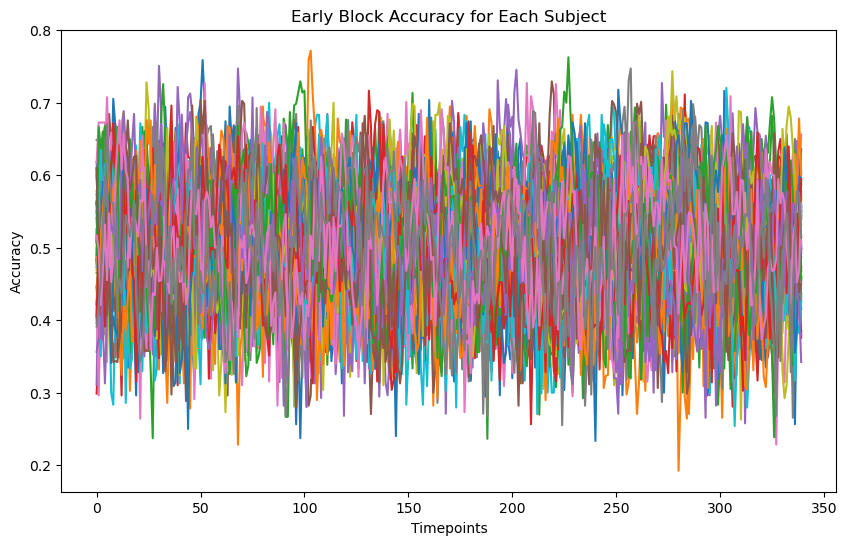

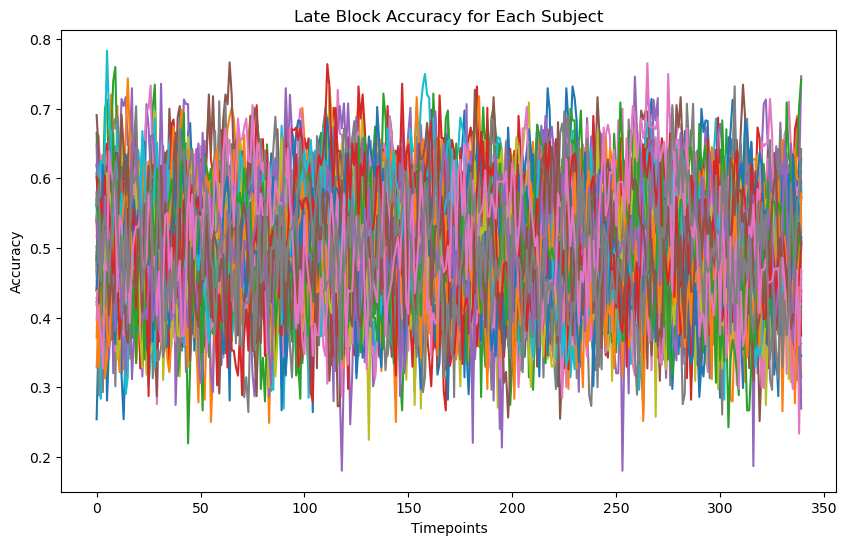

In [5]:
import matplotlib.pyplot as plt

# Plot early block accuracy for each subject
plt.figure(figsize=(10, 6))  # Create a figure with custom size
for i in range(n_subjs):  # Loop through each subject
    plt.plot(accuracy_early_all[i], label=f"Subject {subjs[i]}")  # Plot accuracy for each subject
plt.title("Early Block Accuracy for Each Subject")
plt.xlabel("Timepoints")
plt.ylabel("Accuracy")
plt.show()

# Plot late block accuracy for each subject
plt.figure(figsize=(10, 6))  # Create a figure with custom size
for i in range(n_subjs):  # Loop through each subject
    plt.plot(accuracy_late_all[i], label=f"Subject {subjs[i]}")  # Plot accuracy for each subject
plt.title("Late Block Accuracy for Each Subject")
plt.xlabel("Timepoints")
plt.ylabel("Accuracy")
plt.show()


# Try neural network classification (Optional)

In [112]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier

# Early block
# Split data into training and testing (80% train, 20% test)
early_x_train, early_x_test, early_y_train, early_y_test = train_test_split(
    early_x_2d, early_y, test_size=0.2, stratify=early_y)
# take out random variable
# 20% test
# features = channels
# samples = trials

# Train a neural network classifier on the training data
# The network has one hidden layer with 10 neurons
nn_early = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
nn_early.fit(early_x_train, early_y_train)

# Predict
early_y_pred = nn_early.predict(early_x_test)

# Evaluate
acc_early = accuracy_score(early_y_test, early_y_pred)
cm_early = confusion_matrix(early_y_test, early_y_pred)

print("=== Early Block ===")
print("Accuracy on held-out data: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(cm_early)

# Late block
# Split data into training and testing (80% train, 20% test)
late_x_train, late_x_test, late_y_train, late_y_test = train_test_split(
    late_x_2d, late_y, test_size=0.2, stratify=late_y)
# take out random variable
# 20% test
# features = channels
# samples = trials

# Train a neural network classifier on the training data
# The network has one hidden layer with 10 neurons
nn_late = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
nn_late.fit(late_x_train, late_y_train)

# Predict
late_y_pred = nn_late.predict(late_x_test)

# Evaluate
acc_late = accuracy_score(late_y_test, late_y_pred)
cm_late = confusion_matrix(late_y_test, late_y_pred)

print("=== Late Block ===")
print("Accuracy on held-out data: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(cm_late)

# why does the confusion matrix look so weird?


pathname_read = r'/Users/ygao/Desktop/Yifan/PTM/study3/data/EEG/exportfiles_v3'

if os.path.exists(pathname_read):
    print("The directory exists.")
else:
    print("The directory does not exist.")

#subjs = ['0020', '0021']
subjs = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029',
        '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038',
        '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049',
        '0050', '0051', '0052', '0053', '0054', '0055', '0057', '0058', '0059',
        '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069']
#0056 didn't have EEG
#0039 had insufficient segments for k-fold cross-validation
n_subjs = len(subjs)

accuracy_early_all = []
accuracy_late_all = []

for subj in subjs: 
    print("Loading data: PTM_{}".format(subj))

    matA1 = loadmat(pathname_read + r'/PTM_' + subj + r'_A_blk1.mat')
    matA2 = loadmat(pathname_read + r'/PTM_' + subj + r'_A_blk3.mat')
    matB1 = loadmat(pathname_read + r'/PTM_' + subj + r'_B_blk1.mat')
    matB2 = loadmat(pathname_read + r'/PTM_' + subj + r'_B_blk3.mat')

    # sanity check for matrix size
    #print(matA1['Fz'].shape)
    #print(matA2['Fz'].shape)
    #print(matB1['Fz'].shape)
    #print(matB2['Fz'].shape)

    # merge all channels into third dimension
    channel_names = ['Fp1', 'Fz', 'F3', 'LH', 'F7', 'FC5', 'FC1', 'C3', 'LM', 'CP5', 'CP1', 
                 'Pz', 'P3', 'P7', 'O1', 'POz', 'FCz', 'VEOG', 'P4', 'P8', 'RM', 'CP6', 
                 'CP2', 'Cz', 'C4', 'O2', 'F8', 'FC6', 'FC2', 'F4', 'RH', 'Fp2']

    mat_names = ['matA1', 'matA2', 'matB1', 'matB2']
    
    # stack all channels and make 3D matrices
    for mat_name in mat_names:
        mat_data = globals()[mat_name] #loop through all mat types
        
        chan_data = []
        for chan in channel_names:
            if chan in mat_data:
                chan_data.append(mat_data[chan])
    
        mat_3d = np.stack(chan_data, axis=-1) #stack the 2d matrix of all channels
    
        globals()[f"{mat_name}_3d"] = mat_3d
        #print(f"{mat_name}_3d shape:", mat_3d.shape)
    
    # create corresponding label matrices
    matA1_label = np.ones(matA1_3d.shape[0])
    matA2_label = np.ones(matA2_3d.shape[0])
    matB1_label = np.zeros(matB1_3d.shape[0])
    matB2_label = np.zeros(matB2_3d.shape[0])

    # append the A and B matrices together into early and late x and y matrices
    early_x = np.concatenate((matA1_3d, matB1_3d), axis=0)
    early_y = np.append(matA1_label,matB1_label)
    #print(early_x.shape)
    #print(early_y.shape)
    #print(early_y)
    
    late_x = np.concatenate((matA2_3d, matB2_3d), axis=0)
    late_y = np.append(matA2_label,matB2_label)
    #print(late_x.shape)
    #print(late_y.shape)
    #print(late_y)

    # run SVM for whole brain across each time point
    accuracy_early = []
    accuracy_late = []
    
    # Run the model for early block
    for i in range(0, early_x.shape[1]):
        #print(early_x[:,1,:].shape)
        early_x_ti = early_x[:,i,:]
        #print(early_x_ti.shape)
    
        X = early_x_ti
        y = early_y
        
        # Create a KFold object with k=5
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
        
        # Initialize an empty list to store accuracy scores
        acc_ti = []
        
        # Iterate through the folds
        for train_index, test_index in kf.split(X,y):
            # Split the data into training and testing sets
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # The network has one hidden layer with 10 neurons
            nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
            nn.fit(X_train, y_train)

            # Predict
            y_pred = nn.predict(X_test)

            # Calculate accuracy and append to the list
            acc_fold = accuracy_score(y_test, y_pred)
            acc_ti.append(acc_fold)
        
        # Calculate the average accuracy across all folds
        avg_acc_ti = np.mean(acc_ti)
        #print(avg_acc_ti)
        
        # Print the accuracy scores for each fold and the average accuracy
        #print("Accuracy scores for each fold:", accuracy_scores)
        #print("Average accuracy:", average_accuracy)
    
        # Save average accuracy scores for a single time point
        accuracy_early.append(avg_acc_ti)

    # append single subject accuracy scores together
    accuracy_early_all.append(accuracy_early)
    
    # Run the model for late block
    for i in range(0, late_x.shape[1]):
        #print(late_x[:,1,:].shape)
        late_x_ti = late_x[:,i,:]
        #print(late_x_ti.shape)
    
        X = late_x_ti
        y = late_y
        
        # Create a KFold object with k=5
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
        
        # Initialize an empty list to store accuracy scores
        acc_ti = []
        
        # Iterate through the folds
        for train_index, test_index in kf.split(X,y):
            # Split the data into training and testing sets
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # The network has one hidden layer with 10 neurons
            nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
            nn.fit(X_train, y_train)

            # Predict
            y_pred = nn.predict(X_test)

            # Calculate accuracy and append to the list
            acc_fold = accuracy_score(y_test, y_pred)
            acc_ti.append(acc_fold)
        
        # Calculate the average accuracy across all folds
        avg_acc_ti = np.mean(acc_ti)
        #print(avg_acc_ti)
        
        # Print the accuracy scores for each fold and the average accuracy
        #print("Accuracy scores for each fold:", accuracy_scores)
        #print("Average accuracy:", average_accuracy)
    
        # Save average accuracy scores for a single time point
        accuracy_late.append(avg_acc_ti)
    

    # append single subject accuracy scores together
    accuracy_late_all.append(accuracy_late)

accuracy_early_all = np.array(accuracy_early_all)
accuracy_late_all = np.array(accuracy_late_all)

=== Early Block ===
Accuracy on held-out data: 92.93%
Confusion Matrix:
[[4 1]
 [3 3]]
=== Late Block ===
Accuracy on held-out data: 92.93%
Confusion Matrix:
[[3 3]
 [2 5]]
